# Data Processing with Batching

2022-07-13

Zooey Nguyen

IMPORTANT: We have to manually create a separate HDF5 file for validation and testing, the datagen doesn't do the split itself.

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from DataMaker import *

IMAGE_SHAPE = (120,120,5)
BATCH_SIZE = 128
DATA_PATH = "/data/HSC/HSC_v9/five_band_image120x120.hdf5"

In [2]:
hf = h5py.File(DATA_PATH)
print(list(hf.keys()))
print(hf['specz'][0])
print(hf['specz'][0].shape)
print(hf['image'][0].shape)

['image', 'specz']
[0.06925]
(1,)
(5, 120, 120)


In [3]:
dataset_size = hf['specz'].shape[0]
train_size = int(dataset_size * 0.7)
val_size = dataset_size - train_size
train_size

157272

In [4]:
train_gen = HDF5ImageGenerator(
    src=DATA_PATH,
    X_key='image',
    y_key='specz',
    scaler=False,
    labels_encoding=False,
    batch_size=32,
    mode='train'
)

## example item from the generator

(32, 5, 120, 120)
(32, 1)


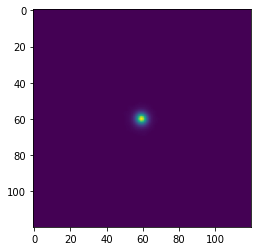

In [5]:
import matplotlib.pyplot as plt

print(train_gen.__getitem__(0)[0].shape)
print(train_gen.__getitem__(0)[1].shape)
plt.imshow(train_gen.__getitem__(0)[0][0][0])

## you can use the generator for training now here's a little dummy dum model that doesnt do anything

In [6]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [8]:
model.fit(train_gen)

7022/7022 [==============================] - 315s 45ms/step - loss: 140.6250


(-1.0, 3.0)

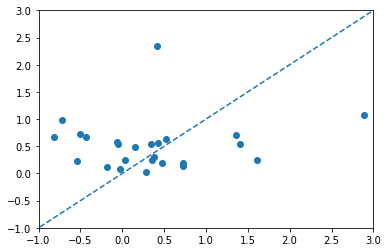

In [24]:
from sklearn.metrics import mean_squared_error as mse
# actually there are points wayyyy outside this but idc this is a dummy example
# we can obscure a little fake results. as a treat
preds = model.predict(train_gen.__getitem__(0)[0])
y = train_gen.__getitem__(0)[1]
mse(preds, y)
plt.scatter(preds, y)
plt.plot([-3, 4], [-3, 4], ls="--")
plt.xlim([-1,3])
plt.ylim([-1,3])